# 算法链与管道
### 通过将Pipeline和GridSearchCV结合,简化数据处理过程

In [1]:
#导入相关模块
import pandas as pd
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import mglearn
%matplotlib inline

#忽略弹出的warnings
import warnings
warnings.filterwarnings('ignore')  
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [2]:
#简短代码实现数据划分,数据缩放和模型训练
from sklearn.svm import SVC
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score 

#加载缩放数据
cancer = load_breast_cancer()
scaler_data = MinMaxScaler().fit(cancer.data).transform(cancer.data)

#划分数据
x_train,x_test,y_train,y_test = train_test_split(scaler_data,cancer.target,random_state=0,test_size=0.3)

#构建模型
model = SVC().fit(x_train,y_train)

#打印AUC分数
auc_svc = roc_auc_score(y_test,model.decision_function(x_test))
print(auc_svc)

0.988536155203


## 用预处理进行参数选择

In [4]:
#寻找最佳参数,缺陷:事先将测试数据泄露给模型
from sklearn.model_selection import GridSearchCV
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'gamma': [0.001, 0.01, 0.1, 1, 10, 100]} #SVM 模型参数组合
#重构模型
model = GridSearchCV(SVC(),param_grid=param_grid,cv=10).fit(x_train,y_train)

#打印
print("最佳交叉验证精度(accurary):",model.best_score_)
print("最佳准确率(precision):",model.score(x_test,y_test))
print("最佳参数组合:",model.best_params_)

最佳交叉验证精度(accurary): 0.977386934673
最佳准确率(precision): 0.976608187135
最佳参数组合: {'C': 10, 'gamma': 0.1}


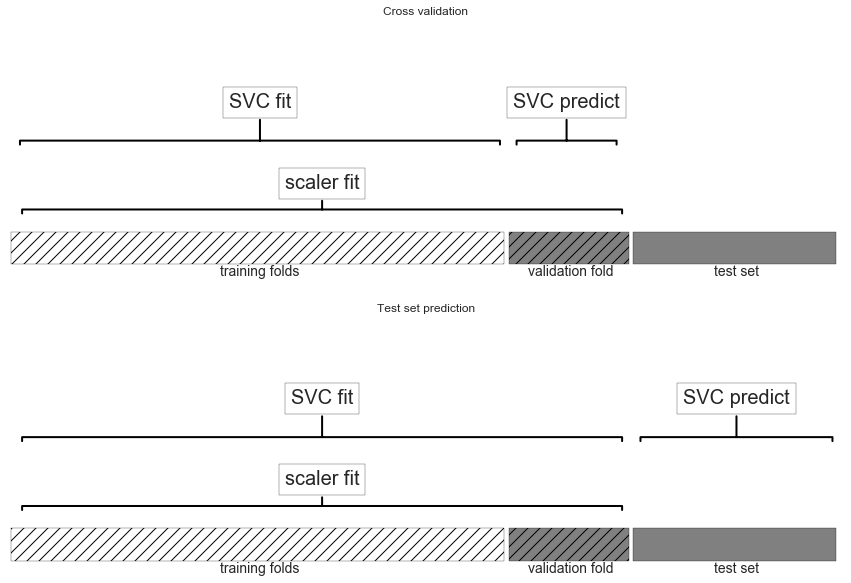

In [5]:
mglearn.plots.plot_improper_processing() #缺陷:事先将测试数据泄露给模型

## 构建管道

In [13]:
from sklearn.svm import SVC
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score 
from sklearn.pipeline import Pipeline

#加载划分数据
cancer = load_breast_cancer()
x_train,x_test,y_train,y_test = train_test_split(cancer.data,cancer.target,random_state=0,test_size=0.3)

#构建管道
pipe=Pipeline([("scaler",MinMaxScaler()),("svm",SVC())]) #同时实现数据缩放和分类器构建

pipe.fit(x_train,y_train)

#打印AUC
auc_svc = roc_auc_score(y_test,pipe.decision_function(x_test))
print("AUC分数:",auc_svc)

AUC分数: 0.988536155203


## 在网络搜索中使用管道

In [20]:
from sklearn.model_selection import GridSearchCV


param_grid = {'svm__C': [0.001, 0.01, 0.1, 1, 10, 100],
             'svm__gamma': [0.001, 0.01, 0.1, 1, 10, 100]} #SVM 模型参数组合

#重构模型
model = GridSearchCV(pipe,param_grid=param_grid,cv=5).fit(x_train,y_train)

#打印
print("最佳交叉验证模型精度(accurary):",model.best_score_)
print("最佳准确率(precision):",model.score(x_test,y_test))
print("最佳参数组合:",model.best_params_)

最佳交叉验证精度(accurary): 0.979899497487
最佳准确率(precision): 0.970760233918
最佳参数组合: {'svm__C': 100, 'svm__gamma': 0.1}


## 通用的管道接口

In [21]:
def fit(self,X,y):
    """模型函数"""
    X_transformed = X
    for name,estimator in self.steps[:-1]:
        #遍历除了最后一步之外的所有步骤
        #对数据进行拟合和变频
        X_transformed = estimator.fit_transform(X_transformed,y)
        #对最后一步进行拟合
        self.steps[-1][1].fit(X_transformed,y)
        return self
    
def predict(self,X):
    """预测函数"""
    X_transformed = X
    for name,estimator in self.steps[:-1]:
        #遍历除了最后一步之外的所有步骤
        #对数据进行拟合和变频
        X_transformed = estimator.fit_transform(X_transformed,y)
        #利用最后一步进行预测
        return self.steps[-1][1].predict(X_transformed)

In [22]:
#例子
from sklearn.preprocessing import  StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

pipe = make_pipeline(StandardScaler(),PCA(n_components=2),StandardScaler())
print(pipe.steps)

[('standardscaler-1', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('standardscaler-2', StandardScaler(copy=True, with_mean=True, with_std=True))]


In [24]:
#访问管道属性
pipe.fit(cancer.data)
#提取主成分
pipe.named_steps["pca"].components_.shape

(2, 30)

## 网络搜索选择使用哪个模型

In [33]:
#到底选择SVM模型还是randomForestClassirer模型或者是逻辑回归模型

#导入三个分类器
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression

#导入并划分数据
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer

cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, random_state=0)

#构建管道
from sklearn.pipeline import Pipeline
pipe = Pipeline([("preprocessing",StandardScaler()),("classifier",SVC())])

#构建网络搜索参数组合
param_grid = [{"classifier":[SVC()],"preprocessing":[StandardScaler(),None],
              "classifier__gamma":[0.001,0.01,0.1,1,10,100],
              "classifier__C": [0.001,0.01,0.1,1,10,100]},
             {"classifier" : [RandomForestClassifier(n_estimators=100)],
             "preprocessing":[None],"classifier__max_features":[1,2,3]},
             {"classifier":[LinearRegression()],"preprocessing":[StandardScaler(),None]}]

#实现网络搜索
from sklearn.model_selection import GridSearchCV
model_select = GridSearchCV(pipe,param_grid=param_grid,cv=5).fit(X_train,y_train)

#打印
print("最佳参数:",model_select.best_params_)
print("最佳模型精度:",model_select.best_score_)
print("最佳泛化能力:",model_select.score(X_test,y_test))

最佳参数: {'classifier': SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False), 'classifier__C': 10, 'classifier__gamma': 0.01, 'preprocessing': StandardScaler(copy=True, with_mean=True, with_std=True)}
最佳模型精度: 0.985915492958
最佳泛化能力: 0.979020979021
